In [1]:
# Libraries

import os
import pandas
import platform
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.report import report_load
from source.python.report import report_concat
from source.python.report import report_filter
from source.python.report import report_plot
from source.python.io     import loader
from source.python.io     import writer
from source.python        import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

In [4]:
# List reports folder content

ROOT_DIR = os.path.join(ROOT, 'reports', '2023-06-xx')
DATA_DIR = os.path.join(ROOT, 'output', 'nbp13-report')

shutil.rmtree(DATA_DIR, ignore_errors = True)
os.makedirs(DATA_DIR, exist_ok = True)

for index, name in enumerate(os.listdir(ROOT_DIR), start = 0) :
	path_l0 = os.path.join(ROOT_DIR, name)

	if index == 0 : print('{} :'.format(path_l0))
	else          : print('\n{} :'.format(path_l0))

	for name in os.listdir(path_l0) :
		print('...\\{}'.format(name))

	print()

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert :
...\fc3-cat-v1-12-3-72-po0512-adam-f2-0250-global-mean
...\fc3-cat-v1-12-3-72-po0512-adam-f3-0250-global-mean
...\fc3-cat-v1-12-3-77-po0512-adam-f2-0250-tissue-mean-explode
...\fc3-cat-v1-12-3-77-po4096-adam-f2-0250-tissue-mean-explode
...\fc3-cat-v2-12-3-72-po0512-adam-f2-0250-global-mean
...\fc3-cat-v2-12-3-72-po4096-adam-f2-0250-global-mean
...\fc3-def-v1-12-3-72-po0512-adam-f2-0250-global-mean
...\fc3-def-v1-12-3-72-po0512-adam-f2-0250-tissue-mean-explode
...\fc3-def-v1-12-3-72-po0512-adam-f3-0250-global-mean
...\fc3-def-v1-12-6-72-po0512-adam-f2-0250-global-mean
...\fc3-def-v2-12-3-72-po0512-adam-f2-0250-global-mean
...\fc3-rnn-v1-12-3-72-po0512-adam-f2-0250-global-mean
...\fc3-rnn-v1-12-3-72-po0512-adam-f2-0250-tissue-mean-seedling
...\fc3-rnn-v1-12-3-72-po0512-adam-f3-0250-global-mean
...\fc3-rnn-v1-12-3-72-po0512-adam-f3-0250-tissue-mean-explode
...\fc3-rnn-v1-12-3-72-po0512-adam-f3-0250

In [5]:
# Load existing configurations

CONFIG_DIR = os.path.join(ROOT, 'resources', 'tuner')

ZCONFIG_PATH = os.path.join(CONFIG_DIR, 'zrimec.json')
WCONFIG_PATH = os.path.join(CONFIG_DIR, 'washburn.json')

ZCONFIG = list()
WCONFIG = list()

CONFIG_MAX       = 100
CONFIG_BEST      = 10
CONFIG_OVERWRITE = True
CONFIG_EXTEND    = False

if os.path.exists(ZCONFIG_PATH) and CONFIG_EXTEND :
	ZCONFIG = loader.load_json(filename = ZCONFIG_PATH)

	print('Sucessufully loaded configuration [{:88s}] with [{:2d}] elements'.format(ZCONFIG_PATH, len(ZCONFIG)))
	print()

if os.path.exists(WCONFIG_PATH) and CONFIG_EXTEND :
	WCONFIG = loader.load_json(filename = WCONFIG_PATH)

	print('Sucessufully loader configuration [{:88s}] with [{:2d}] elements'.format(WCONFIG_PATH, len(WCONFIG)))
	print()

# 1. Tuner

## 1.1 Model

In [6]:
# Load tune model reports

report_tune_model = report_load.load_cnn_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 5
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\zrimec-tf2150-f2-0250-25-77-tissue-mean-explode\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\zrimec-tf2150-f2-1000-25-72-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\zrimec-tf2150-f2-1000-25-72-tissue-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\zrimec-tf2150-f3-1000-25-72-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\zrimec-tf2150-f3-1000-25-72-tissue-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\zrimec-tf2150-f3-1000-25-77-tissue-mean-explode\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\washburn-tf21

### 1.1.1 Regression

In [7]:
# Display overall regression prediction

R2_THRESHOLD = 0.00

for key, dataframe in report_tune_model['regression'].items() :
	nan_mse = dataframe['valid_loss'].isnull().values.ravel().sum()
	pos_r2  = dataframe[dataframe['valid_r2'] > R2_THRESHOLD]['valid_r2'].count()
	neg_r2  = dataframe[dataframe['valid_r2'] < R2_THRESHOLD]['valid_r2'].count()

	print('{:50s} : Size = {:4d} || NaN Loss = {:4d} || Pos R2 = {:4d} || Neg R2 = {:4d}'.format(key, len(dataframe), nan_mse, pos_r2, neg_r2))

print()

zrimec-tf2150-f2-0250-25-77-tissue-mean-explode    : Size =  250 || NaN Loss =    0 || Pos R2 =  144 || Neg R2 =  106
zrimec-tf2150-f2-1000-25-72-global-mean            : Size = 1000 || NaN Loss =    0 || Pos R2 =  211 || Neg R2 =  789
zrimec-tf2150-f2-1000-25-72-tissue-mean            : Size = 1000 || NaN Loss =    0 || Pos R2 =  253 || Neg R2 =  747
zrimec-tf2150-f3-1000-25-72-global-mean            : Size = 1000 || NaN Loss =    0 || Pos R2 =  201 || Neg R2 =  799
zrimec-tf2150-f3-1000-25-72-tissue-mean            : Size = 1000 || NaN Loss =    0 || Pos R2 =  118 || Neg R2 =  882
zrimec-tf2150-f3-1000-25-77-tissue-mean-explode    : Size =  527 || NaN Loss =    0 || Pos R2 =  107 || Neg R2 =  420
washburn-tf2150-f2-0250-25-72-global-mean          : Size =  250 || NaN Loss =    0 || Pos R2 =  106 || Neg R2 =  144
washburn-tf2150-f2-0250-25-77-tissue-mean-explode  : Size =   68 || NaN Loss =    0 || Pos R2 =   42 || Neg R2 =   26
washburn-tf2150-f3-0250-25-72-global-mean          : Siz

In [8]:
# Concat reports and display top few

report = report_concat.concat_cnn_tune_reports(
	reports = report_tune_model,
	mode    = 'regression',
	n       = None
)

report_all = report.copy()

if report_all is not None :
	report_all['Sequence'] = report_all['Sequence'].replace('tf2150', 'transcript 2150 bp')
	report_all['Sequence'] = report_all['Sequence'].replace('tf6150', 'transcript 6150 bp')
	report_all['Sequence'] = report_all['Sequence'].replace('po0512', 'promoter 512 bp')
	report_all['Sequence'] = report_all['Sequence'].replace('po4096', 'promoter 4096 bp')
	report_all['Sequence'] = report_all['Sequence'].replace('po4096', 'promoter + 5\'utr 4096 bp')

	report_all = report_all.head(n = 25)

report_all

,Model,Sequence,Filter,Target0,Target1,Target2,ID,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Epoch,Optimizer,LR,Decay,Scheduler,Batch,Dropout
0,washburn,transcript 2150 bp,f2,tissue,mean,explode,00cba03f,0.59248,0.61172,0.38111,0.56393,25,adam,0.00011,0.00131,exponential,128,0.38577
1,washburn,transcript 2150 bp,f2,global,mean,None,0aae48fb,0.52645,0.58152,0.36605,0.47133,25,adam,0.00045,0.00427,exponential,64,0.29941
2,washburn,transcript 2150 bp,f2,global,mean,None,f51cebb3,0.53337,0.58431,0.35554,0.51450,25,adam,0.00099,0.00151,exponential,64,0.43530
3,washburn,transcript 2150 bp,f2,global,mean,None,4548521c,0.53282,0.58129,0.35317,0.41561,25,adam,0.00077,0.00129,exponential,64,0.28059
4,washburn,transcript 2150 bp,f2,global,mean,None,bee383ba,0.53173,0.58400,0.35024,0.50471,25,adam,0.00080,0.00050,exponential,64,0.42083
5,washburn,transcript 2150 bp,f2,global,mean,None,b90062dc,0.53196,0.58439,0.34999,0.51084,25,adam,0.00099,0.00102,exponential,64,0.44015
6,washburn,transcript 2150 bp,f2,global,mean,None,b0f4ed89,0.53169,0.58040,0.34990,0.48990,25,adam,0.00085,0.00009,exponential,64,0.38222
7,washburn,transcript 2150 bp,f2,global,mean,None,db1ae8c0,0.54671,0.58969,0.34480,0.56282,25,adam,0.00051,0.00006,exponential,128,0.44822
8,washburn,transcript 2150 bp,f2,global,mean,None,2fab7736,0.54411,0.59471,0.33699,0.56324,25,adam,0.00096,0.00010,exponential,64,0.48045
9,washburn,transcript 2150 bp,f2,tissue,mean,explode,55366054,0.63531,0.63431,0.33695,0.61946,25,adam,0.00030,0.00950,exponential,128,0.45289


In [9]:
# Only zrimec

report_zrimec = report.copy()

if report_zrimec is not None :
	report_zrimec = report_zrimec[report_zrimec['Model'] == 'zrimec'].copy()
	report_zrimec = report_zrimec.head(n = 10)

	report_zrimec['Target'] = report_zrimec[['Target0', 'Target1', 'Target2']].agg(lambda x : '-'.join(x.dropna()), axis = 1)

	old_cols = report_zrimec.columns.tolist()
	new_cols = old_cols[-1:] + old_cols[:-1]
	report_zrimec = report_zrimec[new_cols]

	report_zrimec = report_zrimec.reset_index(drop = True)
	report_zrimec = report_zrimec.drop(columns = ['Target0', 'Target1', 'Target2', 'Model', 'Sequence', 'ID', 'Epoch'])

report_zrimec

,Target,Filter,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Optimizer,LR,Decay,Scheduler,Batch,Dropout
0,tissue-mean-explode,f2,0.62579,0.63254,0.32945,0.52591,adam,0.00100,0.00612,exponential,64,0.32453
1,tissue-mean-explode,f2,0.62990,0.63730,0.32704,0.48591,adam,0.00052,0.00798,exponential,64,0.46294
2,tissue-mean-explode,f2,0.63884,0.63585,0.32487,0.52432,adam,0.00091,0.00872,exponential,128,0.31345
3,tissue-mean-explode,f2,0.65130,0.63688,0.31206,0.52178,adam,0.00100,0.01169,exponential,128,0.32155
4,tissue-mean-explode,f2,0.64274,0.63770,0.31124,0.48474,adam,0.00052,0.01309,exponential,64,0.31159
5,tissue-mean-explode,f2,0.64600,0.64039,0.31033,0.53357,adam,0.00072,0.01155,exponential,64,0.27717
6,tissue-mean-explode,f2,0.66637,0.66347,0.29829,0.54868,adam,0.00043,0.02257,exponential,128,0.32719
7,tissue-mean-explode,f2,0.66296,0.65198,0.29223,0.38561,adam,0.00019,0.01184,exponential,64,0.41975
8,global-mean,f2,0.56345,0.60986,0.28949,0.41555,adam,0.00025,0.08397,exponential,32,0.21959
9,global-mean,f2,0.56549,0.61617,0.28901,0.51123,adam,0.00033,0.08510,exponential,32,0.22969


In [10]:
# Only washburn

report_washburn = report.copy()

if report_washburn is not None :
	report_washburn = report_washburn[report_washburn['Model'] == 'washburn'].copy()
	report_washburn = report_washburn.head(n = 10)

	report_washburn['Target'] = report_washburn[['Target0', 'Target1', 'Target2']].agg(lambda x : '-'.join(x.dropna()), axis = 1)

	old_cols = report_washburn.columns.tolist()
	new_cols = old_cols[-1:] + old_cols[:-1]
	report_washburn = report_washburn[new_cols]

	report_washburn = report_washburn.reset_index(drop = True)
	report_washburn = report_washburn.drop(columns = ['Target0', 'Target1', 'Target2', 'Model', 'Sequence', 'ID', 'Epoch'])

report_washburn

,Target,Filter,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Optimizer,LR,Decay,Scheduler,Batch,Dropout
0,tissue-mean-explode,f2,0.59248,0.61172,0.38111,0.56393,adam,0.00011,0.00131,exponential,128,0.38577
1,global-mean,f2,0.52645,0.58152,0.36605,0.47133,adam,0.00045,0.00427,exponential,64,0.29941
2,global-mean,f2,0.53337,0.58431,0.35554,0.51450,adam,0.00099,0.00151,exponential,64,0.43530
3,global-mean,f2,0.53282,0.58129,0.35317,0.41561,adam,0.00077,0.00129,exponential,64,0.28059
4,global-mean,f2,0.53173,0.58400,0.35024,0.50471,adam,0.00080,0.00050,exponential,64,0.42083
5,global-mean,f2,0.53196,0.58439,0.34999,0.51084,adam,0.00099,0.00102,exponential,64,0.44015
6,global-mean,f2,0.53169,0.58040,0.34990,0.48990,adam,0.00085,0.00009,exponential,64,0.38222
7,global-mean,f2,0.54671,0.58969,0.34480,0.56282,adam,0.00051,0.00006,exponential,128,0.44822
8,global-mean,f2,0.54411,0.59471,0.33699,0.56324,adam,0.00096,0.00010,exponential,64,0.48045
9,tissue-mean-explode,f2,0.63531,0.63431,0.33695,0.61946,adam,0.00030,0.00950,exponential,128,0.45289


In [11]:
# Save top model configurations (to same format as model params)

for key in report_tune_model['regression'].keys() :
	df = report_tune_model['regression'][key]
	df = df.sort_values('valid_r2', ascending = False)

	if   key.startswith('zrimec')   : config = ZCONFIG
	elif key.startswith('washburn') : config = WCONFIG
	else : raise ValueError()

	if   key.startswith('zrimec')   : layers = [3, 3]
	elif key.startswith('washburn') : layers = [6, 3]
	else : raise ValueError()

	for i in range(CONFIG_BEST) :
		item = {
			'id' : 'id'
		}

		temp = df.iloc[i, :].to_dict()

		if 'trial_id' in temp.keys() :
			item['id'] = item['id'] + '_{:s}'.format(temp['trial_id'])

		if 'pid' in temp.keys() :
			item['id'] = item['id'] + '_{:d}'.format(temp['pid'])

		for k, v in temp.items() :
			if   k.startswith('valid')  : pass
			elif k.startswith('train')  : pass
			elif k.startswith('config') : k = k[7:]
			else : continue

			if k.startswith('model/convx/') :
				for i in range(2, layers[0] + 1) :
					oldkey = 'x/'
					newkey = str(i) + '/'

					item[k.replace(oldkey, newkey)] = v

			elif k.startswith('model/maxpoolx/') :
				for i in range(1, layers[1] + 1) :
					oldkey = 'x/'
					newkey = str(i) + '/'

					item[k.replace(oldkey, newkey)] = v

			else :
				item[k] = v


		config.append(item)

ZCONFIG = sorted(ZCONFIG, key = lambda x : x['valid_r2'], reverse = True)
WCONFIG = sorted(WCONFIG, key = lambda x : x['valid_r2'], reverse = True)

ZCONFIG = ZCONFIG[:CONFIG_MAX]
WCONFIG = WCONFIG[:CONFIG_MAX]

if CONFIG_OVERWRITE :
	if len(ZCONFIG) > 0 :
		writer.write_json(filename = ZCONFIG_PATH, data = ZCONFIG)

		print('Sucessufully written configuration [{:88s}] with [{:2d}] elements'.format(ZCONFIG_PATH, len(ZCONFIG)))

	if len(WCONFIG) > 0 :
		writer.write_json(filename = WCONFIG_PATH, data = WCONFIG)

		print('Sucessufully written configuration [{:88s}] with [{:2d}] elements'.format(WCONFIG_PATH, len(WCONFIG)))

	print()

Sucessufully written configuration [C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner\zrimec.json      ] with [60] elements
Sucessufully written configuration [C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner\washburn.json    ] with [40] elements



### 1.1.2 Classification

In [12]:
# Concat reports and display top few

report = report_concat.concat_cnn_tune_reports(
	reports = report_tune_model,
	mode    = 'classification',
	n       = None
)

report

## 1.2 Data

In [13]:
# Display top few results for each tune configuration

report_tune_data = report_load.load_data_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 25
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-data\zrimec-tf2150-f2-1000-25-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-data\zrimec-tf2150-f3-1000-25-global-mean\report.csv


### 1.2.1 Regression

In [14]:
# Concat reports and display top few

report = report_concat.concat_data_tune_reports(
	reports = report_tune_data,
	mode    = 'regression',
	n       = None
)

if report is not None :
	report_data = report.copy()

	report_data['Target'] = report_data[['Target0', 'Target1', 'Target2']].agg(lambda x : '-'.join(x.dropna()), axis = 1)

	old_cols = report_data.columns.tolist()
	new_cols = old_cols[-1:] + old_cols[:-1]
	report_data = report_data[new_cols]

	report_data = report_data.drop(columns = ['Target0', 'Target1', 'Target2', 'Sequence'])
	report_data = report_data.head(n = 25)
else :
	report_data = None

report_data

,Target,Model,Filter,ID,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Epoch,Lambda
0,global-mean,zrimec,f2,cf66b026,0.33411,0.47798,0.28553,0.30709,25,-0.28488
1,global-mean,zrimec,f2,cd45df25,0.34065,0.47275,0.27195,0.30832,25,-0.28565
2,global-mean,zrimec,f2,665ab49c,0.28373,0.44508,0.25938,0.27629,20,-0.34268
3,global-mean,zrimec,f2,1dd7540e,0.28452,0.44892,0.24376,0.26937,20,-0.34805
4,global-mean,zrimec,f2,0b35c8f2,0.28180,0.44932,0.23536,0.26160,25,-0.35110
5,global-mean,zrimec,f2,6163696c,0.27950,0.45006,0.21565,0.25188,25,-0.36097
6,global-mean,zrimec,f2,e6e233d2,0.39500,0.52743,0.21523,0.34281,20,-0.26807
7,global-mean,zrimec,f2,7570d7d5,0.16729,0.35049,0.17474,0.15854,25,-0.53683
8,global-mean,zrimec,f2,837186cc,0.15452,0.33809,0.15710,0.14579,25,-0.57129
9,global-mean,zrimec,f2,393946e8,0.21809,0.40315,0.15563,0.19548,25,-0.45687


In [15]:
# Display top reports and checkpoints (log2, boxcox)

report_b = report.head(n = 5)
report_0 = report[report['Lambda'] ==  '0.00000']
report_i = report[report['Lambda'] == '-0.14']

report_t = pandas.concat((report_b, report_0))
report_t = pandas.concat((report_i, report_t))

report_t

,Model,Sequence,Filter,Target0,Target1,Target2,ID,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Epoch,Lambda
0,zrimec,tf2150,f2,global,mean,None,cf66b026,0.33411,0.47798,0.28553,0.30709,25,-0.28488
1,zrimec,tf2150,f2,global,mean,None,cd45df25,0.34065,0.47275,0.27195,0.30832,25,-0.28565
2,zrimec,tf2150,f2,global,mean,None,665ab49c,0.28373,0.44508,0.25938,0.27629,20,-0.34268
3,zrimec,tf2150,f2,global,mean,None,1dd7540e,0.28452,0.44892,0.24376,0.26937,20,-0.34805
4,zrimec,tf2150,f2,global,mean,None,0b35c8f2,0.28180,0.44932,0.23536,0.26160,25,-0.35110
535,zrimec,tf2150,f3,global,mean,None,95d80bf1,1.54572,0.96221,-0.50567,1.02673,5,0.00000
804,zrimec,tf2150,f2,global,mean,None,4c932e4c,3.64122,1.57901,-1.22476,1.38312,5,0.00000


### 1.2.2 Classification

In [16]:
# Concat reports and display top few

report_data = report_concat.concat_data_tune_reports(
	reports = report_tune_data,
	mode    = 'classification',
	n       = None
)

if report is not None :
	report_data = report.copy()

	report_data['Target'] = report_data[['Target0', 'Target1', 'Target2']].agg(lambda x : '-'.join(x.dropna()), axis = 1)

	old_cols = report_data.columns.tolist()
	new_cols = old_cols[-1:] + old_cols[:-1]
	report_data = report_data[new_cols]

	report_data = report_data.drop(columns = ['Target0', 'Target1', 'Target2', 'Sequence'])
	report_data = report_data.head(n = 25)
else :
	report_data = None

report_data

,Target,Model,Filter,ID,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Epoch,Lambda
0,global-mean,zrimec,f2,cf66b026,0.33411,0.47798,0.28553,0.30709,25,-0.28488
1,global-mean,zrimec,f2,cd45df25,0.34065,0.47275,0.27195,0.30832,25,-0.28565
2,global-mean,zrimec,f2,665ab49c,0.28373,0.44508,0.25938,0.27629,20,-0.34268
3,global-mean,zrimec,f2,1dd7540e,0.28452,0.44892,0.24376,0.26937,20,-0.34805
4,global-mean,zrimec,f2,0b35c8f2,0.28180,0.44932,0.23536,0.26160,25,-0.35110
5,global-mean,zrimec,f2,6163696c,0.27950,0.45006,0.21565,0.25188,25,-0.36097
6,global-mean,zrimec,f2,e6e233d2,0.39500,0.52743,0.21523,0.34281,20,-0.26807
7,global-mean,zrimec,f2,7570d7d5,0.16729,0.35049,0.17474,0.15854,25,-0.53683
8,global-mean,zrimec,f2,837186cc,0.15452,0.33809,0.15710,0.14579,25,-0.57129
9,global-mean,zrimec,f2,393946e8,0.21809,0.40315,0.15563,0.19548,25,-0.45687


## 1.3 Feature

In [17]:
# Display top few results for each tune configuration

report_tune_feature = report_load.load_feature_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 25
)

### 1.3.1 Regression

In [18]:
# Concat reports and display top few

report = report_concat.concat_feature_tune_reports(
	reports = report_tune_feature,
	mode    = 'regression',
	n       = None
)

if report is not None :
	report = report[report['Target1'] == 'mean'].head(n = 50)

report

### 1.3.2 Classification

In [19]:
# Concat reports and display top few

report = report_concat.concat_feature_tune_reports(
	reports = report_tune_feature,
	mode    = 'classification',
	n       = 25
)

report

# 2. CNN

## 2.1 Model

In [20]:
# Load cnn model reports

report_cnn_model = report_load.load_cnn_reports(
	root = ROOT_DIR
)

### 2.1.1 Regression

In [21]:
# Display model performance for regression

if len(report_cnn_model['regression']) > 0 :
	report = report_cnn_model['regression']
else :
	report = None

report

### 2.1.2 Classification

In [22]:
# Display model performance for classification

if len(report_cnn_model['classification']) > 0 :
	report = report_cnn_model['classification']
else :
	report = None

report

## 2.2 Bert

In [23]:
# Load bert cnn model reports

report_cnn_model = report_load.load_bert_cnn_reports(
	root = ROOT_DIR
)

### 2.2.1 Regression

In [24]:
# Display model performance for regression

if len(report_cnn_model['regression']) > 0 :
	report = report_cnn_model['regression']
else :
	report = None

report

,Model,Sequence,Filter,KMer,Features,Target0,Target1,Target2,Optimizer,LR,Beta1,Beta2,Decay,Dropout,Scheduler,Gamma,Batch,Epoch,MSE,R2
6,fex-fc3,po0512,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,162,0.39106,0.10363
5,fex-fc3,po4096,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,135,0.40133,0.06458
7,fex-fc3,tf2150,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,200,0.40267,0.05982
4,fex-fc3,pu4096,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,54,0.40803,0.01545
1,fex-fc3,po4096,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,6,0.46026,-0.08497
0,fex-fc3,pu4096,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,8,0.46661,-0.08185
3,fex-fc3,tf2150,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,14,0.47781,-0.07887
2,fex-fc3,po0512,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,12,0.46008,-0.05472


### 2.2.2 Classification

In [25]:
# Display model performance for classification

if len(report_cnn_model['classification']) > 0 :
	report = report_cnn_model['classification']
else :
	report = None

report

# 3. Bert

## 3.1 Model

In [26]:
# Load bert model reports

report_bert_model = report_load.load_bert_reports(
	root = ROOT_DIR,
	show = False
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f2-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f2-0250-tissue-mean-explode
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f3-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-def-v1-12-6-72-po0512-adam-f2-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-def-v2-12-3-72-po0512-adam-f2-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-rnn-v1-12-3-72-po0512-adam-f2-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-rnn-v1-12-3-72-po0512-adam-f2-0250-tissue-mean-seedl

### 3.1.1 Plot

In [27]:
# Approximate value used for non-explode reports (512 x 32 = 16384)

STEPS_PER_EPOCH = 512

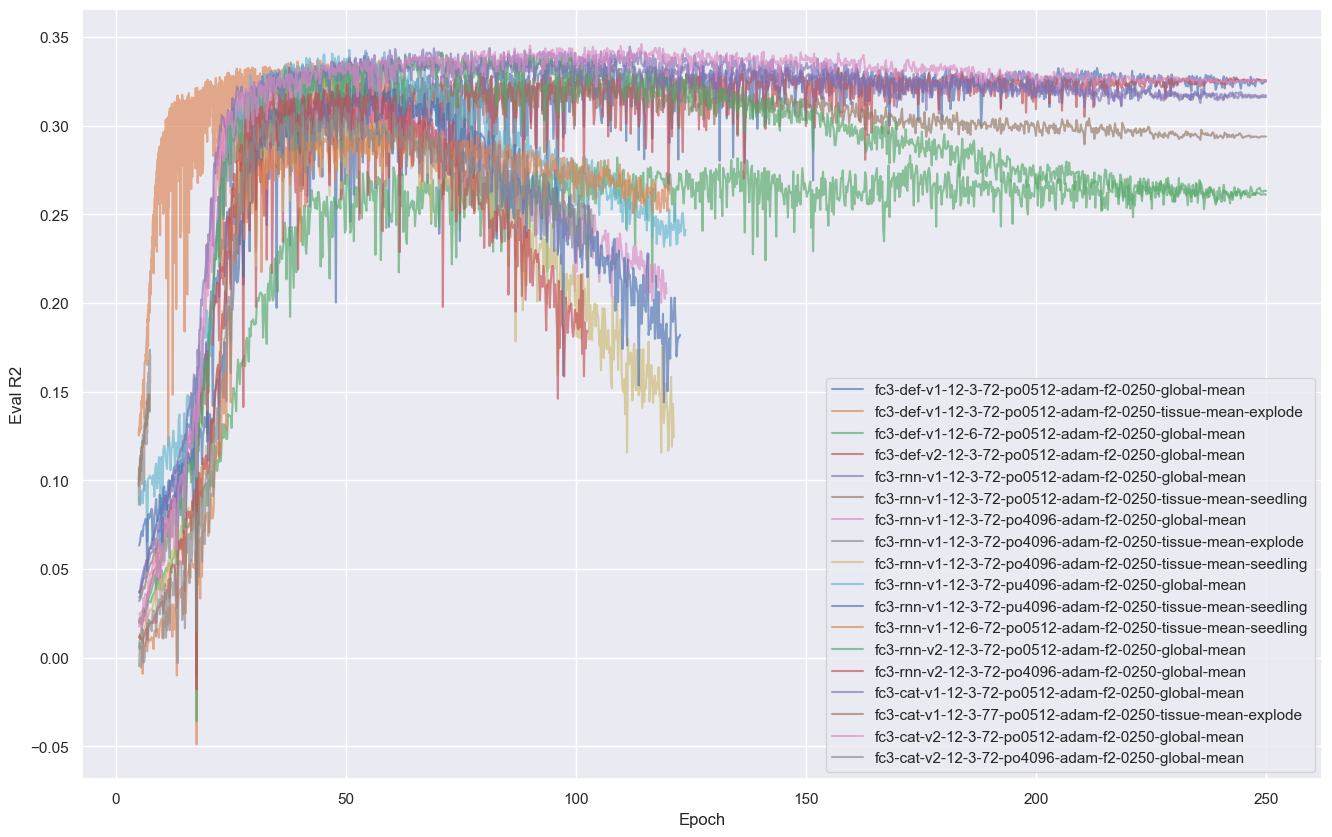

In [28]:
# Plot filter 2

report_plot.models_bert_r2(
	data = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = ['f2'],
		drop_only = []
	),
	mode            = 'regression',
	step            = 'epoch',
	steps_min       = int(  5 * STEPS_PER_EPOCH),
	steps_max       = int(250 * STEPS_PER_EPOCH),
	steps_per_epoch = STEPS_PER_EPOCH,
	alpha           = 0.65,
	groupby         = 'none',
	filename        = os.path.join(DATA_DIR, 'bert-r2-f2')
)

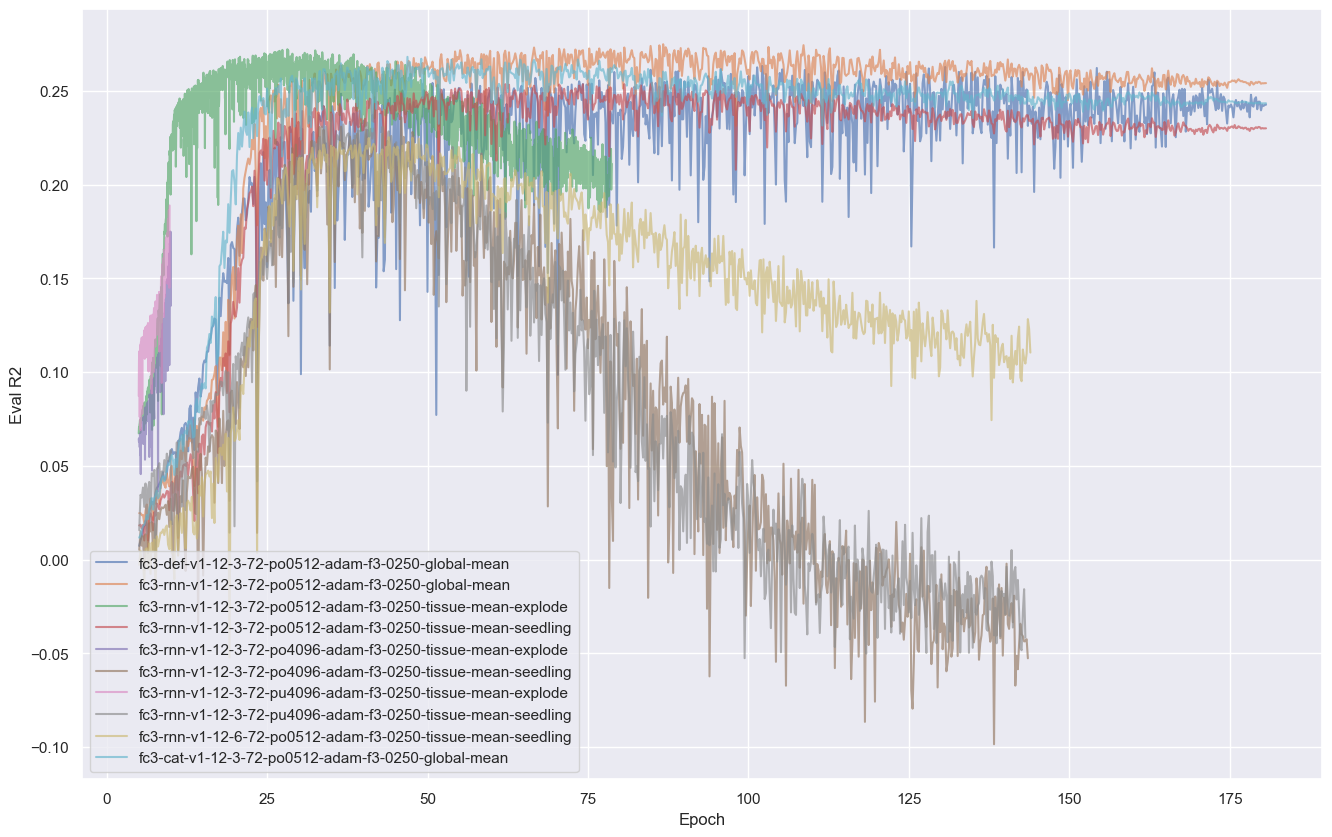

In [29]:
# Plot filter 3

report_plot.models_bert_r2(
	data = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = ['f3'],
		drop_only = []
	),
	mode            = 'regression',
	step            = 'epoch',
	steps_min       = int(  5 * STEPS_PER_EPOCH),
	steps_max       = int(250 * STEPS_PER_EPOCH),
	steps_per_epoch = STEPS_PER_EPOCH,
	alpha           = 0.65,
	groupby         = 'none',
	filename        = os.path.join(DATA_DIR, 'bert-r2-f3')
)

### 3.1.2 Regression

In [30]:
# Concat reports and display top few

report = report_concat.concat_bert_reports(
	data            = report_bert_model,
	mode            = 'regression',
	metric          = 'eval_r2',
	ascending       = False,
	steps_per_epoch = STEPS_PER_EPOCH
)

if report is not None :
	report['Target'] = report[['Target0', 'Target1', 'Target2']].agg(lambda x : '-'.join(x.dropna()), axis = 1)

	old_cols = report.columns.tolist()
	new_cols = old_cols[-1:] + old_cols[:-1]
	report = report[new_cols]

	report['Pooler'] = report['Pooler'].replace('def', 'first')
	report['Pooler'] = report['Pooler'].replace('dna', 'mean')

	report['Sequence'] = report['Sequence'].replace('tf2150', 'transcript 2150 bp')
	report['Sequence'] = report['Sequence'].replace('po0512', 'promoter 512 bp')
	report['Sequence'] = report['Sequence'].replace('po4096', 'promoter 4096 bp')
	report['Sequence'] = report['Sequence'].replace('pu4096', 'promoter + 5\'utr 4096 bp')

	report = report.rename(columns = {
		'Epochs' : 'Epoch_Max',
		'Epoch'  : 'Epoch_Best'
	})

	report = report.drop(columns = ['Target0', 'Target1', 'Target2', 'Mode', 'Arch', 'LR', 'Steps', 'Step'])
	report = report.reset_index(drop = True)

report

,Target,Pooler,Type,Layer,Kmer,Feature,Filter,Sequence,Optimizer,Eval_R2,Eval_ME,Eval_MAPE,Eval_MAE,Epoch_Max,Epoch_Best
0,global-mean,mean,cat,12,3,72,f2,promoter 512 bp,adam,0.34600,2.98904,1.59827,0.59079,250.0,114.3
1,global-mean,first,rnn,12,3,72,f2,promoter 512 bp,adam,0.34468,3.02678,1.54737,0.59707,250.0,111.7
2,global-mean,first,rnn,12,3,72,f2,promoter + 5'utr 4096 bp,adam,0.34270,3.29499,1.63542,0.59551,123.8,50.8
3,global-mean,mean,rnn,12,3,72,f2,promoter 512 bp,adam,0.34117,2.99235,1.58085,0.59831,250.0,70.7
4,global-mean,first,cat,12,3,72,f2,promoter 512 bp,adam,0.34046,3.08325,1.55781,0.59836,250.0,89.1
5,tissue-mean-explode,first,def,12,3,72,f2,promoter 512 bp,adam,0.33763,3.30029,12.69585,0.63056,59.8,59.7
6,global-mean,first,def,12,3,72,f2,promoter 512 bp,adam,0.33506,3.00240,1.61010,0.60534,250.0,106.2
7,global-mean,mean,def,12,3,72,f2,promoter 512 bp,adam,0.33276,3.12639,1.58130,0.60313,250.0,146.1
8,tissue-mean-seedling,first,rnn,12,3,72,f2,promoter 512 bp,adam,0.32664,3.20777,14.57904,0.61994,250.2,66.8
9,tissue-mean-seedling,first,rnn,12,3,72,f2,promoter + 5'utr 4096 bp,adam,0.32656,3.30183,14.64238,0.62329,122.7,54.3


In [31]:
# Display kmer check (3, 4, 5, 6)

x = report
x = x[x['Pooler']   == 'first']
x = x[x['Type']     == 'def']
x = x[x['Filter']   == 'f2']
x = x[x['Sequence'] == 'promoter 512 bp']
x = x[x['Target']   == 'global-mean']

x.reset_index(drop = True)

,Target,Pooler,Type,Layer,Kmer,Feature,Filter,Sequence,Optimizer,Eval_R2,Eval_ME,Eval_MAPE,Eval_MAE,Epoch_Max,Epoch_Best
0,global-mean,first,def,12,3,72,f2,promoter 512 bp,adam,0.33506,3.00240,1.61010,0.60534,250.0,106.2
1,global-mean,first,def,12,6,72,f2,promoter 512 bp,adam,0.28333,3.32778,1.58115,0.62930,250.0,172.7


In [32]:
# Display filter check (f1, f2, f3, f4, f5, f6)

x = report
x = x[x['Pooler']   == 'first']
x = x[x['Type']     == 'def']
x = x[x['Kmer']     == 3]
x = x[x['Sequence'] == 'promoter 512 bp']
x = x[x['Target']   == 'global-mean']

x.reset_index(drop = True)

,Target,Pooler,Type,Layer,Kmer,Feature,Filter,Sequence,Optimizer,Eval_R2,Eval_ME,Eval_MAPE,Eval_MAE,Epoch_Max,Epoch_Best
0,global-mean,first,def,12,3,72,f2,promoter 512 bp,adam,0.33506,3.00240,1.61010,0.60534,250.0,106.2
1,global-mean,first,def,12,3,72,f3,promoter 512 bp,adam,0.26337,3.06501,0.30586,0.45235,180.7,102.1


In [33]:
# Display pooler check (first, mean)

x = report
x = x[x['Type']     == 'def']
x = x[x['Kmer']     == 3]
x = x[x['Filter']   == 'f2']
x = x[x['Sequence'] == 'promoter 512 bp']
x = x[x['Target']   == 'global-mean']

x.reset_index(drop = True)

,Target,Pooler,Type,Layer,Kmer,Feature,Filter,Sequence,Optimizer,Eval_R2,Eval_ME,Eval_MAPE,Eval_MAE,Epoch_Max,Epoch_Best
0,global-mean,first,def,12,3,72,f2,promoter 512 bp,adam,0.33506,3.00240,1.61010,0.60534,250.0,106.2
1,global-mean,mean,def,12,3,72,f2,promoter 512 bp,adam,0.33276,3.12639,1.58130,0.60313,250.0,146.1


In [34]:
# Display architecture check (def, cat, rnn)

x = report
x = x[x['Pooler']   == 'first']
x = x[x['Kmer']     == 3]
x = x[x['Filter']   == 'f2']
x = x[x['Sequence'] == 'promoter 512 bp']
x = x[x['Target']   == 'global-mean']

x.reset_index(drop = True)

,Target,Pooler,Type,Layer,Kmer,Feature,Filter,Sequence,Optimizer,Eval_R2,Eval_ME,Eval_MAPE,Eval_MAE,Epoch_Max,Epoch_Best
0,global-mean,first,rnn,12,3,72,f2,promoter 512 bp,adam,0.34468,3.02678,1.54737,0.59707,250.0,111.7
1,global-mean,first,cat,12,3,72,f2,promoter 512 bp,adam,0.34046,3.08325,1.55781,0.59836,250.0,89.1
2,global-mean,first,def,12,3,72,f2,promoter 512 bp,adam,0.33506,3.00240,1.61010,0.60534,250.0,106.2


In [35]:
# Display sequence check (tf2150, po0512, po4096, pu4096)

x = report
x = x[x['Pooler']   == 'first']
x = x[x['Type']     == 'rnn']
x = x[x['Kmer']     == 3]
x = x[x['Filter']   == 'f2']
x = x[x['Target']   == 'global-mean']

x.reset_index(drop = True)

,Target,Pooler,Type,Layer,Kmer,Feature,Filter,Sequence,Optimizer,Eval_R2,Eval_ME,Eval_MAPE,Eval_MAE,Epoch_Max,Epoch_Best
0,global-mean,first,rnn,12,3,72,f2,promoter 512 bp,adam,0.34468,3.02678,1.54737,0.59707,250.0,111.7
1,global-mean,first,rnn,12,3,72,f2,promoter + 5'utr 4096 bp,adam,0.34270,3.29499,1.63542,0.59551,123.8,50.8
2,global-mean,first,rnn,12,3,72,f2,promoter 4096 bp,adam,0.32171,3.29793,1.68455,0.61259,119.7,37.7
